<h2 style='color:green'>데이터 로딩 부분<h2>

In [36]:
import os
import pandas as pd

def load_motor_data(base_path, motor_numbers):
    data = {'normal': [], 'abnormal': []}

    for motor in motor_numbers:
        # 정상 데이터 경로
        normal_path = os.path.join(base_path, "normal", str(motor), "time_vib")
        if os.path.exists(normal_path):
            normal_files = [os.path.join(normal_path, file) for file in os.listdir(normal_path) if file.endswith('.csv')]
            for file in normal_files:
                df = pd.read_csv(file, header=None, names=['time', 'vibration'])
                data['normal'].append(df['vibration'].values)

        # 비정상 데이터 경로
        abnormal_path = os.path.join(base_path, "abnormal", str(motor), "time_vib")
        if os.path.exists(abnormal_path):
            abnormal_files = [os.path.join(abnormal_path, file) for file in os.listdir(abnormal_path) if file.endswith('.csv')]
            for file in abnormal_files:
                df = pd.read_csv(file, header=None, names=['time', 'vibration'])
                data['abnormal'].append(df['vibration'].values)

    return data

# Train/Test Split
train_motors = range(1, 17)  # 모터 1~16번: Train
test_motors = range(17, 21)  # 모터 17~20번: Test

base_path = "./motor_data"

# Train 데이터 로드
train_data = load_motor_data(base_path, train_motors)
print(train_data)
# Test 데이터 로드
test_data = load_motor_data(base_path, test_motors)



{'normal': [array([ 0.20192,  0.27868,  0.12515, ..., -0.14352, -0.48896, -0.14352]), array([ 0.08606, -0.02909,  0.4315 , ...,  0.0093 , -0.221  ,  0.20121]), array([ 0.50729,  0.00832,  0.46891, ...,  0.12347,  0.00832, -0.26035]), array([-0.52843, -0.06784,  0.31598, ...,  0.0473 ,  0.16245, -0.10623]), array([ 0.20106,  0.12429, -0.25953, ...,  0.35459,  0.16267,  0.20106]), array([ 0.16391, -0.52697, -0.18153, ..., -0.41182, -0.14315, -0.14315]), array([ 0.20241, -0.18142, -0.29656, ..., -0.56524,  0.04888, -0.41171]), array([0.08494, 0.50714, 0.23846, ..., 0.04655, 0.04655, 0.35361]), array([ 0.35504, -0.06717, -0.18232, ..., -0.06717,  0.04798,  0.31665]), array([-0.10548, -0.259  ,  0.20158, ...,  0.00967, -0.4893 ,  0.00967]), array([-0.14405,  0.31654,  0.12463, ..., -0.41272, -0.14405,  0.00948]), array([-0.29697, -0.48889, -0.06668, ...,  0.08685,  0.24038, -0.10506]), array([ 0.12425,  0.12425, -0.1828 , ..., -0.22118,  0.04749, -0.33633]), array([-0.29641, -0.37318, -0.06

<h2 style='color:green'>정상, 비정상 데이터 끼리 묶기<h2>

In [37]:
import numpy as np

def combine_csv_data(data):
    combined_data = {}
    combined_data['normal'] = np.concatenate(data['normal'])  # 정상 데이터 결합
    combined_data['abnormal'] = np.concatenate(data['abnormal'])  # 비정상 데이터 결합
    return combined_data

# Train/Test 데이터 결합
train_combined = combine_csv_data(train_data)
test_combined = combine_csv_data(test_data)

# 출력 테스트
# print("Train Normal Data Shape:", train_combined['normal'].shape)
# print("Train Abnormal Data Shape:", train_combined['abnormal'].shape)
# print("Test Normal Data Shape:", test_combined['normal'].shape)
# print("Test Abnormal Data Shape:", test_combined['abnormal'].shape)



In [38]:
normal = np.concatenate((train_combined['normal'],test_combined['normal']),axis=0)
abnormal = np.concatenate((train_combined['abnormal'],test_combined['abnormal']),axis=0)
df_normal = pd.DataFrame(normal,columns=['진동']) # 정상 데이터
df_abnormal = pd.DataFrame(abnormal,columns=['진동']) # 비정상 데이터

print("정상 데이터\n",df_normal.describe())
print("비정상 데이터\n",df_abnormal.describe()) 

정상 데이터
                  진동
count  2.126848e+06
mean  -3.679624e-08
std    1.907138e-01
min   -7.954600e-01
25%   -1.444200e-01
50%    9.070000e-03
75%    1.625600e-01
max    7.013000e-01
비정상 데이터
                  진동
count  2.131968e+06
mean   1.923106e-10
std    3.243456e-01
min   -1.027590e+00
25%   -2.223575e-01
50%    9.560000e-03
75%    2.400800e-01
max    9.693400e-01


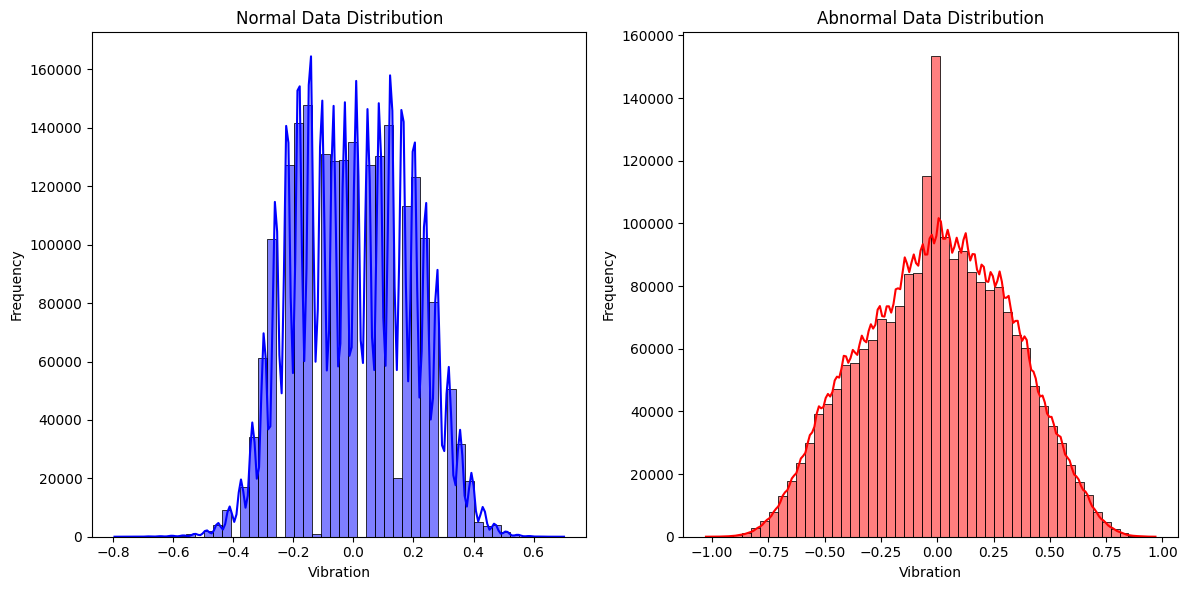

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# 히스토그램과 KDE 플롯을 사용하여 분포 시각화
plt.figure(figsize=(12, 6))

# 정상 데이터 분포
plt.subplot(1, 2, 1)
sns.histplot(df_normal['진동'], kde=True, color='blue', bins=50)
plt.title("Normal Data Distribution")
plt.xlabel("Vibration")
plt.ylabel("Frequency")

# 비정상 데이터 분포
plt.subplot(1, 2, 2)
sns.histplot(df_abnormal['진동'], kde=True, color='red', bins=50)
plt.title("Abnormal Data Distribution")
plt.xlabel("Vibration")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

<h2 style='color:green'>데이터 reshape<h2>

In [40]:
from sklearn.preprocessing import MinMaxScaler
"""
# Train/Test 데이터를 정규화
scaler = MinMaxScaler()
"""
train_normal = train_combined['normal'].reshape(-1)
test_normal = test_combined['normal'].reshape(-1)

train_abnormal = train_combined['abnormal'].reshape(-1)
test_abnormal = test_combined['abnormal'].reshape(-1)

train_normal

array([0.20192, 0.27868, 0.12515, ..., 0.20034, 0.04682, 0.04682])

<h2 style='color:green'>데이터 슬라이싱 후 특징 추출<h2>

In [41]:
import numpy as np

# 슬라이딩 윈도우 방식의 데이터 슬라이싱 및 통계 feature 추출 함수
def extract_statistical_features_sliding(data, window_size=256, step=1):
    """
    데이터를 슬라이딩 윈도우 방식으로 자르고 통계적 특징을 추출합니다.
    :param data: 입력 데이터 (numpy array)
    :param window_size: 윈도우 크기
    :param step: 슬라이딩 간격
    :return: 슬라이싱된 데이터의 통계적 특징 (2D 배열)
    """
    features = []
    for i in range(0, len(data) - window_size + 1, step):
        slice_data = data[i:i + window_size]

        # 통계적 특징 추출
        mean = np.mean(slice_data)
        variance = np.var(slice_data)
        rms = np.sqrt(np.mean(slice_data**2))  # Root Mean Square
        skewness = np.mean((slice_data - mean)**3) / (np.std(slice_data)**3)  # 왜도
        kurtosis = np.mean((slice_data - mean)**4) / (np.std(slice_data)**4)  # 첨도

        # feature 추가
        features.append([mean, variance, rms, skewness, kurtosis])
    
    return np.array(features)

# 데이터 슬라이싱 및 feature 추출
train_normal_features = extract_statistical_features_sliding(train_normal, window_size=256, step=128)
test_normal_features = extract_statistical_features_sliding(test_normal, window_size=256, step=128)
train_abnormal_features = extract_statistical_features_sliding(train_abnormal, window_size=256, step=128)
test_abnormal_features = extract_statistical_features_sliding(test_abnormal, window_size=256, step=128)

# 결과 확인
print("Train Normal Features Shape:", train_normal_features.shape)
print("Test Normal Features Shape:", test_normal_features.shape)
print("Train Abnormal Features Shape:", train_abnormal_features.shape)
print("Test Abnormal Features Shape:", test_abnormal_features.shape)


Train Normal Features Shape: (13287, 5)
Test Normal Features Shape: (3327, 5)
Train Abnormal Features Shape: (13327, 5)
Test Abnormal Features Shape: (3327, 5)


In [42]:
normal_slice = np.concatenate((train_normal_features,test_normal_features),axis=0)
abnormal_slice = np.concatenate((train_abnormal_features,test_abnormal_features),axis=0)
print(normal_slice)

[[ 4.12187500e-04  6.91480019e-02  2.62960400e-01 -4.99964452e-02
   2.32123115e+00]
 [-3.33570312e-03  6.47288171e-02  2.54440453e-01 -9.07610572e-02
   2.23466530e+00]
 [-2.43617187e-03  6.55347089e-02  2.56009070e-01 -1.36134277e-01
   2.10155019e+00]
 ...
 [-3.63617187e-03  3.41352424e-02  1.84793031e-01  1.71807926e-01
   2.09953253e+00]
 [-2.13683594e-03  3.40114713e-02  1.84434372e-01  5.31572803e-02
   2.05267837e+00]
 [ 1.46164063e-03  3.30698587e-02  1.81857073e-01  2.80911195e-02
   2.00708595e+00]]


<h1></h1>

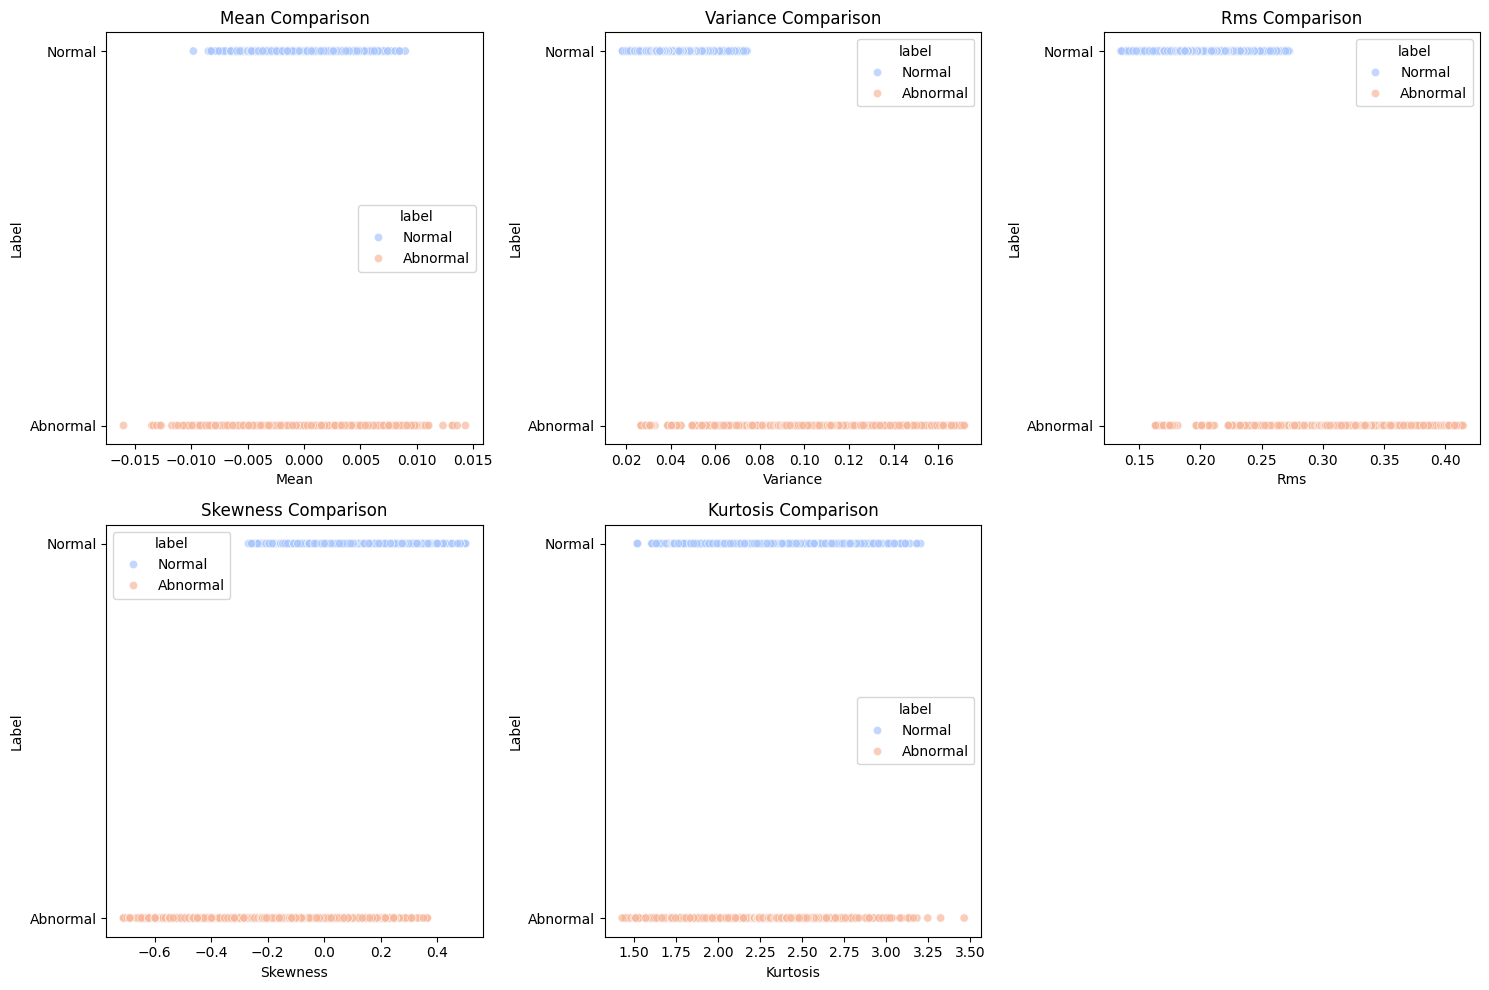

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 통계적 특징을 DataFrame으로 변환
def create_feature_dataframe(features, label):
    df = pd.DataFrame(features, columns=['mean', 'variance', 'rms', 'skewness', 'kurtosis'])
    df['label'] = label
    return df

# 정상 데이터와 비정상 데이터의 통계적 특징을 DataFrame으로 변환
df_train_normal = create_feature_dataframe(train_normal_features, 'Normal')
df_train_abnormal = create_feature_dataframe(train_abnormal_features, 'Abnormal')

# 두 DataFrame을 결합
df_combined = pd.concat([df_train_normal, df_train_abnormal], ignore_index=True)

# 각 특징을 비교하는 scatter plot 생성
features = ['mean', 'variance', 'rms', 'skewness', 'kurtosis']
plt.figure(figsize=(15, 10))

for i, feature in enumerate(features):
    plt.subplot(2, 3, i + 1)
    sns.scatterplot(x=feature, y='label', data=df_combined, hue='label', palette='coolwarm', alpha=0.7)
    plt.title(f'{feature.capitalize()} Comparison')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Label')

plt.tight_layout()
plt.show()

<h2 style='color:green'>BOX PLOT<h2>

/tmp/ipykernel_7575/612072221.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=feature, data=df_combined, palette='coolwarm')
/tmp/ipykernel_7575/612072221.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=feature, data=df_combined, palette='coolwarm')
/tmp/ipykernel_7575/612072221.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=feature, data=df_combined, palette='coolwarm')
/tmp/ipykernel_7575/612072221.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will

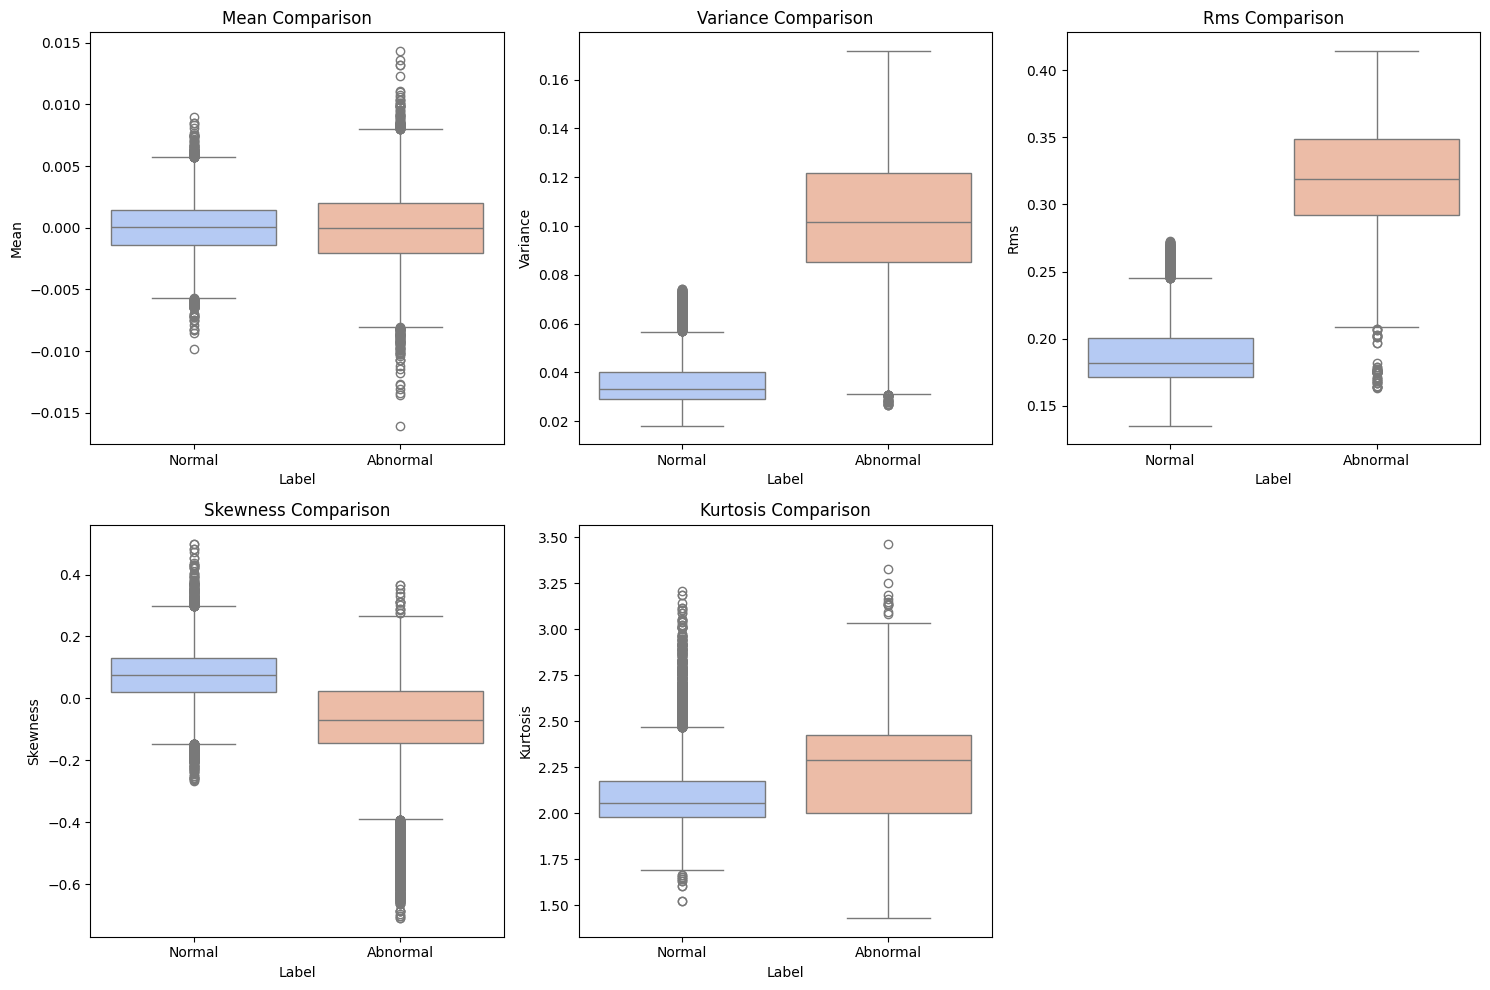

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 통계적 특징을 DataFrame으로 변환하는 함수
def create_feature_dataframe(features, label):
    df = pd.DataFrame(features, columns=['mean', 'variance', 'rms', 'skewness', 'kurtosis'])
    df['label'] = label
    return df

# 정상 데이터와 비정상 데이터의 통계적 특징을 DataFrame으로 변환
df_train_normal = create_feature_dataframe(train_normal_features, 'Normal')
df_train_abnormal = create_feature_dataframe(train_abnormal_features, 'Abnormal')

# 두 DataFrame을 결합
df_combined = pd.concat([df_train_normal, df_train_abnormal], ignore_index=True)

# 각 특징을 비교하는 박스 플롯 생성
features = ['mean', 'variance', 'rms', 'skewness', 'kurtosis']
plt.figure(figsize=(15, 10))

for i, feature in enumerate(features):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x='label', y=feature, data=df_combined, palette='coolwarm')
    plt.title(f'{feature.capitalize()} Comparison')
    plt.xlabel('Label')
    plt.ylabel(feature.capitalize())

plt.tight_layout()
plt.show()

variance랑 rms가 겹침이 적어 학습 데이터셋으로 적합한 것 같습니다

<h2 style='color:pink'>모델 설정 및 학습<h2>

All features

In [45]:
import tensorflow as tf
from tensorflow.keras import layers, models

# 데이터 준비
X_train = train_normal_features
X_test = test_normal_features

# Autoencoder 모델 정의
input_dim = X_train.shape[1]  # feature 개수
encoding_dim = 2  # 압축된 차원 (조정 가능)

# Encoder
input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation="relu")(input_layer)

# Decoder
decoded = layers.Dense(input_dim, activation="sigmoid")(encoded)

# Autoencoder 모델 생성
autoencoder = models.Model(input_layer, decoded)

# 모델 컴파일
autoencoder.compile(optimizer="adam", loss="mse")

# 모델 학습
history = autoencoder.fit(
    X_train, X_train,  # 입력과 출력이 동일
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test, X_test),
    verbose=1   
)

# 모델 평가
print("Training Complete!")


Epoch 1/50
416/416 [==============================] - 1s 1ms/step - loss: 0.4447 - val_loss: 0.2941
Epoch 2/50
416/416 [==============================] - 0s 882us/step - loss: 0.2877 - val_loss: 0.2166
Epoch 3/50
416/416 [==============================] - 0s 894us/step - loss: 0.2579 - val_loss: 0.2094
Epoch 4/50
416/416 [==============================] - 0s 858us/step - loss: 0.2541 - val_loss: 0.2079
Epoch 5/50
416/416 [==============================] - 0s 869us/step - loss: 0.2529 - val_loss: 0.2072
Epoch 6/50
416/416 [==============================] - 0s 862us/step - loss: 0.2524 - val_loss: 0.2068
Epoch 7/50
416/416 [==============================] - 0s 867us/step - loss: 0.2522 - val_loss: 0.2066
Epoch 8/50
416/416 [==============================] - 0s 854us/step - loss: 0.2520 - val_loss: 0.2064
Epoch 9/50
416/416 [==============================] - 0s 874us/step - loss: 0.2519 - val_loss: 0.2063
Epoch 10/50
416/416 [==============================] - 0s 914us/step - loss: 0.2518 

variance, rms,skewness train

In [72]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

# 데이터 준비
# train_normal_features와 test_normal_features에서 variance, rms, skewness 피쳐만 선택
X_train = train_normal_features[:, [1, 2, 3]]  # variance, rms, skewness
X_test = test_normal_features[:, [1, 2, 3]]    # variance, rms, skewness

# Autoencoder 모델 정의
input_dim = X_train.shape[1]  # feature 개수 (3개)
encoding_dim = 2  # 압축된 차원 (조정 가능)

# Encoder
input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation="relu")(input_layer)

# Decoder
decoded = layers.Dense(input_dim, activation="sigmoid")(encoded)

# Autoencoder 모델 생성
autoencoder_second = models.Model(input_layer, decoded)

# 모델 컴파일
autoencoder_second.compile(optimizer="adam", loss="mse")

# 모델 학습
history = autoencoder_second.fit(
    X_train, X_train,  # 입력과 출력이 동일
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test, X_test),
    verbose=1   
)

# 모델 평가
print("Training Complete!")

Epoch 1/50
416/416 [==============================] - 1s 1ms/step - loss: 0.0999 - val_loss: 0.0479
Epoch 2/50
416/416 [==============================] - 0s 1ms/step - loss: 0.0233 - val_loss: 0.0133
Epoch 3/50
416/416 [==============================] - 0s 1ms/step - loss: 0.0081 - val_loss: 0.0063
Epoch 4/50
416/416 [==============================] - 0s 927us/step - loss: 0.0048 - val_loss: 0.0042
Epoch 5/50
416/416 [==============================] - 0s 900us/step - loss: 0.0038 - val_loss: 0.0034
Epoch 6/50
416/416 [==============================] - 0s 946us/step - loss: 0.0034 - val_loss: 0.0031
Epoch 7/50
416/416 [==============================] - 0s 917us/step - loss: 0.0033 - val_loss: 0.0030
Epoch 8/50
416/416 [==============================] - 0s 897us/step - loss: 0.0031 - val_loss: 0.0029
Epoch 9/50
416/416 [==============================] - 0s 899us/step - loss: 0.0030 - val_loss: 0.0028
Epoch 10/50
416/416 [==============================] - 0s 942us/step - loss: 0.0029 - va

<h2 style='color:green'>score<h2>

모든 feature들을 사용하였을 경우

In [89]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

# 데이터 준비
X_train = train_normal_features
X_test = test_normal_features

# Autoencoder 모델 정의
input_dim = X_train.shape[1]  # feature 개수
encoding_dim = 2  # 압축된 차원 (조정 가능)

# Encoder
input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation="relu")(input_layer)

# Decoder
decoded = layers.Dense(input_dim, activation="sigmoid")(encoded)

# Autoencoder 모델 생성
autoencoder = models.Model(input_layer, decoded)

# 모델 컴파일
autoencoder.compile(optimizer="adam", loss="mse")

# 모델 학습
history = autoencoder.fit(
    X_train, X_train,  # 입력과 출력이 동일
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test, X_test),
    verbose=1   
)

# 모델 평가
print("Training Complete!")

# 비정상 데이터 준비
X_test_abnormal = test_abnormal_features

# 테스트 데이터 복원, 정상 데이터 predict
reconstructed_test = autoencoder.predict(X_test)
print("Reconstructed Test Data:", reconstructed_test)

# 비정상 데이터 복원, 비정상 데이터 predict
reconstructed_abnormal = autoencoder.predict(X_test_abnormal)
print("Reconstructed Abnormal Data:", reconstructed_abnormal)

# 재구성 오차 계산 => 복원값과 원래 값의 오차 계산
test_reconstruction_error = np.mean((X_test - reconstructed_test)**2, axis=1)
abnormal_reconstruction_error = np.mean((X_test_abnormal - reconstructed_abnormal)**2, axis=1)

# 임계값 설정 (평균 + 1 * 표준편차)
threshold = np.mean(test_reconstruction_error) + 1 * np.std(test_reconstruction_error)
print("Anomaly Detection Threshold:", threshold)

# 예측 라벨 생성
# test_reconstruction_error는 정상 데이터
# abnormal_reconstruction_error는 비정상 데이터
test_labels = np.zeros(len(test_reconstruction_error))  # 정상 라벨 (0)
abnormal_labels = np.ones(len(abnormal_reconstruction_error))  # 비정상 라벨 (1)

# Combine true labels and reconstruction errors
true_labels = np.concatenate([test_labels, abnormal_labels])
all_reconstruction_errors = np.concatenate([test_reconstruction_error, abnormal_reconstruction_error])

# 예측 라벨 생성: 재구성 오차가 임계값보다 크면 비정상(1), 작으면 정상(0)
predicted_labels = (all_reconstruction_errors > threshold).astype(int)

# F1-score, Precision, Recall 계산
f1 = f1_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
print("F1-score:", f1)
print("Precision:", precision)
print("Recall:", recall)

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels))

Epoch 1/50
416/416 [==============================] - 1s 996us/step - loss: 0.6075 - val_loss: 0.4931
Epoch 2/50
416/416 [==============================] - 0s 826us/step - loss: 0.5046 - val_loss: 0.4095
Epoch 3/50
416/416 [==============================] - 0s 762us/step - loss: 0.4329 - val_loss: 0.3527
Epoch 4/50
416/416 [==============================] - 0s 801us/step - loss: 0.3841 - val_loss: 0.3141
Epoch 5/50
416/416 [==============================] - 0s 783us/step - loss: 0.3505 - val_loss: 0.2875
Epoch 6/50
416/416 [==============================] - 0s 751us/step - loss: 0.3270 - val_loss: 0.2686
Epoch 7/50
416/416 [==============================] - 0s 783us/step - loss: 0.3101 - val_loss: 0.2549
Epoch 8/50
416/416 [==============================] - 0s 745us/step - loss: 0.2976 - val_loss: 0.2446
Epoch 9/50
416/416 [==============================] - 0s 786us/step - loss: 0.2882 - val_loss: 0.2369
Epoch 10/50
416/416 [==============================] - 0s 758us/step - loss: 0.281

variance, rms,skewness

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

# 데이터 준비
# train_normal_features와 test_normal_features에서 variance, rms, skewness 피쳐만 선택
X_train = train_normal_features[:, [1, 2, 3]]  # variance, rms, skewness
X_test = test_normal_features[:, [1, 2, 3]]    # variance, rms, skewness

# Autoencoder 모델 정의
input_dim = X_train.shape[1]  # feature 개수 (3개)
encoding_dim = 2  # 압축된 차원 (조정 가능)

# Encoder
input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation="relu")(input_layer)

# Decoder
decoded = layers.Dense(input_dim, activation="sigmoid")(encoded)

# Autoencoder 모델 생성
autoencoder = models.Model(input_layer, decoded)

# 모델 컴파일
autoencoder.compile(optimizer="adam", loss="mse")

# 모델 학습
history = autoencoder.fit(
    X_train, X_train,  # 입력과 출력이 동일
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test, X_test),
    verbose=1   
)

# 모델 평가
print("Training Complete!")

# 비정상 데이터에서 variance, rms, skewness 피쳐만 선택
X_test_abnormal = test_abnormal_features[:, [1, 2, 3]]  # variance, rms, skewness

# 테스트 데이터 복원, 정상 데이터 predict
reconstructed_test = autoencoder.predict(X_test)
print("Reconstructed Test Data:", reconstructed_test)

# 비정상 데이터 복원, 비정상 데이터 predict
reconstructed_abnormal = autoencoder.predict(X_test_abnormal)
print("Reconstructed Abnormal Data:", reconstructed_abnormal)

# 재구성 오차 계산 => 복원값과 원래 값의 오차 계산
test_reconstruction_error = np.mean((X_test - reconstructed_test)**2, axis=1)
abnormal_reconstruction_error = np.mean((X_test_abnormal - reconstructed_abnormal)**2, axis=1)

# 임계값 설정 (평균 + 1 * 표준편차)
threshold = np.mean(test_reconstruction_error) + 0.07* np.std(test_reconstruction_error)
print("Anomaly Detection Threshold:", threshold)

# 예측 라벨 생성
# test_reconstruction_error는 정상 데이터
# abnormal_reconstruction_error는 비정상 데이터
test_labels = np.zeros(len(test_reconstruction_error))  # 정상 라벨 (0)
abnormal_labels = np.ones(len(abnormal_reconstruction_error))  # 비정상 라벨 (1)

# Combine true labels and reconstruction errors
true_labels = np.concatenate([test_labels, abnormal_labels])
all_reconstruction_errors = np.concatenate([test_reconstruction_error, abnormal_reconstruction_error])

# 예측 라벨 생성: 재구성 오차가 임계값보다 크면 비정상(1), 작으면 정상(0)
predicted_labels = (all_reconstruction_errors > threshold).astype(int)

# F1-score, Precision, Recall 계산
f1 = f1_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)

print("F1-score:", f1)
print("Precision:", precision)
print("Recall:", recall)

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels))

Epoch 1/50
416/416 [==============================] - 1s 962us/step - loss: 0.1117 - val_loss: 0.0498
Epoch 2/50
416/416 [==============================] - 0s 807us/step - loss: 0.0147 - val_loss: 0.0048
Epoch 3/50
416/416 [==============================] - 0s 742us/step - loss: 0.0038 - val_loss: 0.0033
Epoch 4/50
416/416 [==============================] - 0s 856us/step - loss: 0.0034 - val_loss: 0.0030
Epoch 5/50
416/416 [==============================] - 0s 797us/step - loss: 0.0032 - val_loss: 0.0029
Epoch 6/50
416/416 [==============================] - 0s 779us/step - loss: 0.0030 - val_loss: 0.0028
Epoch 7/50
416/416 [==============================] - 0s 760us/step - loss: 0.0028 - val_loss: 0.0027
Epoch 8/50
416/416 [==============================] - 0s 775us/step - loss: 0.0026 - val_loss: 0.0026
Epoch 9/50
416/416 [==============================] - 0s 769us/step - loss: 0.0024 - val_loss: 0.0025
Epoch 10/50
416/416 [==============================] - 0s 765us/step - loss: 0.002

/home/park/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/park/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/park/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/park/myenv/lib/python3.10/site-pa

Epoch 1/50
416/416 [==============================] - 1s 966us/step - loss: 0.0891 - val_loss: 0.0357
Epoch 2/50
416/416 [==============================] - 0s 797us/step - loss: 0.0161 - val_loss: 0.0095
Epoch 3/50
416/416 [==============================] - 0s 758us/step - loss: 0.0059 - val_loss: 0.0052
Epoch 4/50
416/416 [==============================] - 0s 754us/step - loss: 0.0041 - val_loss: 0.0039
Epoch 5/50
416/416 [==============================] - 0s 758us/step - loss: 0.0035 - val_loss: 0.0033
Epoch 6/50
416/416 [==============================] - 0s 748us/step - loss: 0.0033 - val_loss: 0.0031
Epoch 7/50
416/416 [==============================] - 0s 773us/step - loss: 0.0032 - val_loss: 0.0029
Epoch 8/50
416/416 [==============================] - 0s 768us/step - loss: 0.0031 - val_loss: 0.0029
Epoch 9/50
416/416 [==============================] - 0s 749us/step - loss: 0.0030 - val_loss: 0.0028
Epoch 10/50
416/416 [==============================] - 0s 755us/step - loss: 0.002

/home/park/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


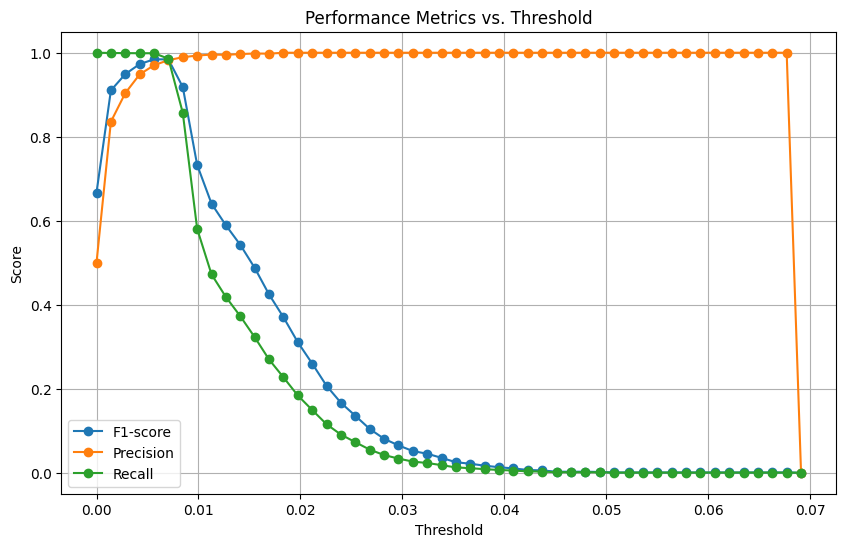

In [91]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt

# 데이터 준비
# train_normal_features와 test_normal_features에서 variance, rms, skewness 피쳐만 선택
X_train = train_normal_features[:, [1, 2, 3]]  # variance, rms, skewness
X_test = test_normal_features[:, [1, 2, 3]]    # variance, rms, skewness

# Autoencoder 모델 정의
input_dim = X_train.shape[1]  # feature 개수 (3개)
encoding_dim = 2  # 압축된 차원 (조정 가능)

# Encoder
input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation="relu")(input_layer)

# Decoder
decoded = layers.Dense(input_dim, activation="sigmoid")(encoded)

# Autoencoder 모델 생성
autoencoder = models.Model(input_layer, decoded)

# 모델 컴파일
autoencoder.compile(optimizer="adam", loss="mse")

# 모델 학습
history = autoencoder.fit(
    X_train, X_train,  # 입력과 출력이 동일
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test, X_test),
    verbose=1   
)

# 모델 평가
print("Training Complete!")

# 비정상 데이터에서 variance, rms, skewness 피쳐만 선택
X_test_abnormal = test_abnormal_features[:, [1, 2, 3]]  # variance, rms, skewness

# 테스트 데이터 복원, 정상 데이터 predict
reconstructed_test = autoencoder.predict(X_test)
print("Reconstructed Test Data:", reconstructed_test)

# 비정상 데이터 복원, 비정상 데이터 predict
reconstructed_abnormal = autoencoder.predict(X_test_abnormal)
print("Reconstructed Abnormal Data:", reconstructed_abnormal)

# 재구성 오차 계산 => 복원값과 원래 값의 오차 계산
test_reconstruction_error = np.mean((X_test - reconstructed_test)**2, axis=1)
abnormal_reconstruction_error = np.mean((X_test_abnormal - reconstructed_abnormal)**2, axis=1)

# Combine true labels and reconstruction errors
test_labels = np.zeros(len(test_reconstruction_error))  # 정상 라벨 (0)
abnormal_labels = np.ones(len(abnormal_reconstruction_error))  # 비정상 라벨 (1)
true_labels = np.concatenate([test_labels, abnormal_labels])
all_reconstruction_errors = np.concatenate([test_reconstruction_error, abnormal_reconstruction_error])

# 임계값 범위 설정
thresholds = np.linspace(np.min(all_reconstruction_errors), np.max(all_reconstruction_errors), 50)

# 성능 지표 저장을 위한 리스트 초기화
f1_scores = []
precisions = []
recalls = []

# 각 임계값에 대해 성능 지표 계산
for threshold in thresholds:
    predicted_labels = (all_reconstruction_errors > threshold).astype(int)
    f1_scores.append(f1_score(true_labels, predicted_labels))
    precisions.append(precision_score(true_labels, predicted_labels))
    recalls.append(recall_score(true_labels, predicted_labels))

# 성능 지표 그래프 시각화
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1-score', marker='o')
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Performance Metrics vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()